# SELICRD Model

S - susceptable, E - exposed, L - latent, I - infected, C - critical, R - recovered, D - dead

Following:
https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7

![title](model.jpg)

In [1]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import matplotlib.dates as mdates
base_dir = 'Data'

First, we define the system of differential equations modelling the flow between compartments

$$\begin{align*}
\dfrac{\delta S}{\delta t} &= - \beta  S \dfrac{I + L}{N}\\
\dfrac{\delta E}{\delta t} &= \beta  S \dfrac{I + L}{N} - \delta  E\\
\dfrac{\delta L}{\delta t} &= \delta  E - \epsilon  p_{L\rightarrow R}  L - \theta  (1 - p_{L\rightarrow R})  L\\
\dfrac{\delta I}{\delta t} &= \theta  (1 - p_{L\rightarrow R})  L - \gamma  (1 - p_{I\rightarrow C})  I  -\lambda  p_{I\rightarrow C}  I\\
\dfrac{\delta C}{\delta t} &= \lambda p_{I\rightarrow C}  I - \tau  \cdot (1 - p_{C\rightarrow D})  \cdot min(beds(t), C) - 
\rho  \cdot p_{C\rightarrow D}  \cdot \min(beds(t), C) - \max(0, C - beds(t))\\
\dfrac{\delta R}{\delta t} &= \gamma  (1 - p_{I\rightarrow R})  I + \tau  (1 - p_{C\rightarrow D})  \cdot \min(beds(t), C) + \epsilon  p_{L\rightarrow R}  L\\
\dfrac{\delta D}{\delta t} &= \rho  \cdot p_{C\rightarrow D}  \cdot min(beds(t), C) + max(0, C-beds(t))
\end{align*}$$

In [2]:
def deriv(y, t, N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds):
    S, E, L, I, C, R, D = y
    dSdt = -beta(t) * S * (I + L) / N
    dEdt = beta(t) * S * (I + L) / N - delta * E
    dLdt = delta * E - epsilon * p_L_to_R * L - theta * (1 - p_L_to_R) * L
    dIdt = theta * (1 - p_L_to_R) * L - gamma * (1 - p_I_to_C) * I  - lamda * p_I_to_C * I
    dCdt = lamda * p_I_to_C * I - tau * (1 - p_C_to_D) * min(beds(t), C) - rho * p_C_to_D * min(beds(t), C) \
           - max(0, C - beds(t))
    dRdt = gamma * (1 - p_I_to_C) * I + tau * (1 - p_C_to_D) * min(beds(t), C) + epsilon * p_L_to_R * L
    dDdt = rho * p_C_to_D * min(beds(t), C) + max(0, C-beds(t))
    return dSdt, dEdt, dLdt, dIdt, dCdt, dRdt, dDdt

We can model the declining R0 as a logistical interpolation as "Stay at Home" orders are released and followed. 

In [3]:
# def logistic_R_0(t, R_0_start, k, x0, R_0_end):
#     if -k*(-t+x0) >= 500: return R_0_end
#     return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
def R0_t(t, b, r_s):
    return (2 / np.pi) * np.arctan(-(t - b) / 10 * r_s) + 1.0

We can find the numerical solution to the ODEs 

In [4]:
# def Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
#     # infection rate comes from current R0
#     def beta(t):
#         return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
#     # model bed usage in the poplation
#     def beds(t):
#         beds_0 = beds_per_10k / 10_000 * N
#         return beds_0 + s*beds_0*t  # 0.003
#     # run model
#     N = sum(agegroups)
#     y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
#     t = np.linspace(0, days, days)
#     ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, beds))
#     S, E, L, I, C, R, D = ret.T
#     R_0_over_time = [beta(i)/gamma for i in range(len(t))]
#     return t, S, E, L, I, C, R, D, R_0_over_time, beds, p_I_to_C, p_C_to_D
def Model(days, agegroups, beds_per_100k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
    def beta(t):
        return alpha*R0_t(t, b, r_s)
    N = sum(agegroups)
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(N, beta, delta, epsilon, p_L_to_R, theta, gamma, p_C_to_D, p_I_to_C, lamda, tau, rho, Beds))
    S, E, L, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/alpha for i in range(len(t))]
    return t, S, E, L, I, C, R, D, R_0_over_time, Beds, p_I_to_C, p_C_to_D

In [5]:
def plotter(t, S, E, L, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None: 
        print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        # ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        # ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, L, 'm', alpha=0.7, linewidth=2, label='Latent')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'c', alpha=0.7, linewidth=2, label='Critical')
        # ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax.title.set_text('SELICRD Model')
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(delta*E[:i]) if sum(delta*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()
    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

Next, define the hyper-parameter rates of the model

In [6]:
gamma = 1.0 / 17.5 # 9 days from infection to recovery
delta = 1.0 / 2.5  # incubation period of four days
epsilon = 1.0 / 14.0 # two weeks for latent person to recover
theta = 1.0 /2.0 # three days for latent to show symptoms
lamda = 1.0 / 11.0 # five days for infected to be critical
tau = 1.0 / 11.5 # week for critical patients to recover
rho = 1.0 / 7.5 # 7.5 days from critical to death

## Parameter Fitting

In [276]:
# params_init_min_max = {"R_0_start": (3.0, 2.0, 10.0), "k": (2.5, 0.01, 10.0), "x0": (57, 20, 100), "R_0_end": (0.9, 0.01, 3.5), "p_L_to_R": (0.6, 0.0, 0.8),
#                        "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
#                        "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

params_init_min_max = {#"R_0_start": (3.0, 2.0, 10.0), "k": (2.5, 0.01, 10.0), "x0": (57, 20, 100), "R_0_end": (0.9, 0.01, 3.5), 
                       "p_L_to_R": (0.6, 0.0, 0.8),
                       "alpha": (0.3, 0.1, 5.7), 
                       "b": (20, 0, 40), "r_s": (1, 0.1, 60),
                       "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}


In [106]:
worldData = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", header = 0)
worldData.rename(columns={"countriesAndTerritories" : "country"}, inplace=True)
worldData["country"].replace({"United_States_of_America": "US"}, inplace=True)
worldData

,dateRep,day,month,year,cases,deaths,country,geoId,countryterritoryCode,popData2018,continentExp
0,01/06/2020,1,6,2020,680,8,Afghanistan,AF,AFG,37172386.0,Asia
1,31/05/2020,31,5,2020,866,3,Afghanistan,AF,AFG,37172386.0,Asia
2,30/05/2020,30,5,2020,623,11,Afghanistan,AF,AFG,37172386.0,Asia
3,29/05/2020,29,5,2020,580,8,Afghanistan,AF,AFG,37172386.0,Asia
4,28/05/2020,28,5,2020,625,7,Afghanistan,AF,AFG,37172386.0,Asia
...,...,...,...,...,...,...,...,...,...,...,...
20706,25/03/2020,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
20707,24/03/2020,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,Africa
20708,23/03/2020,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
20709,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,Africa


In [103]:
set(worldData["country"])

{'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua_and_Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bonaire, Saint Eustatius and Saba',
 'Bosnia_and_Herzegovina',
 'Botswana',
 'Brazil',
 'British_Virgin_Islands',
 'Brunei_Darussalam',
 'Bulgaria',
 'Burkina_Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape_Verde',
 'Cases_on_an_international_conveyance_Japan',
 'Cayman_Islands',
 'Central_African_Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa_Rica',
 'Cote_dIvoire',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'Democratic_Republic_of_the_Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican_Republic',
 'Ecuador',
 'Egypt',
 'El_Salvador',
 'Equatorial_Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fa

In [129]:
country = "Italy"
countryData = worldData[worldData.country == country][::-1].reset_index(drop=True)
countryData

,dateRep,day,month,year,cases,deaths,country,geoId,countryterritoryCode,popData2018,continentExp
0,31/12/2019,31,12,2019,0,0,Italy,IT,ITA,60431283.0,Europe
1,01/01/2020,1,1,2020,0,0,Italy,IT,ITA,60431283.0,Europe
2,02/01/2020,2,1,2020,0,0,Italy,IT,ITA,60431283.0,Europe
3,03/01/2020,3,1,2020,0,0,Italy,IT,ITA,60431283.0,Europe
4,04/01/2020,4,1,2020,0,0,Italy,IT,ITA,60431283.0,Europe
...,...,...,...,...,...,...,...,...,...,...,...
149,28/05/2020,28,5,2020,584,117,Italy,IT,ITA,60431283.0,Europe
150,29/05/2020,29,5,2020,593,70,Italy,IT,ITA,60431283.0,Europe
151,30/05/2020,30,5,2020,516,87,Italy,IT,ITA,60431283.0,Europe
152,31/05/2020,31,5,2020,416,111,Italy,IT,ITA,60431283.0,Europe


In [123]:
def run_and_plot(country, outbreak_shift):
    #deaths
    if country == 'China': 
        countryData = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
        # rename the column header so that it is same as other data
        countryData.rename(columns={'confirmed_ttl':'cases_ttl'}, inplace=True) 
        
#     else: deaths = pd.read_csv("Data/world_cases_deaths_EUopendataportal.csv", header = 0)
    else:
        worldData = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", header = 0)
        worldData.rename(columns={"countriesAndTerritories" : "country"}, inplace=True)
        worldData.rename(columns={"dateRep" : "date"}, inplace=True)
        worldData["country"].replace({"United_States_of_America": "US"}, inplace=True)
        worldData["country"].replace({"United_Kingdom": "UK"}, inplace=True)
        
        countryData = worldData[worldData.country == country][::-1].reset_index(drop=True)
        # create cumulative columns
        countryData["cases_ttl"] = np.cumsum(countryData["cases"])
        countryData["deaths_ttl"] = np.cumsum(countryData["deaths"])
    
    # find the case when equal or more than 100 infection cases detected
    countryData = countryData.loc[countryData["cases_ttl"].values>=100]
    deathData = countryData["deaths_ttl"].values

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    #create outbreak shift
    days = outbreak_shift + len(deathData)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), deathData))
    else: y_data = deathData[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    
    # fit model to deaths
#     def fitter(x, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
#         ret = Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s)
#         return ret[7][x]
    def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
        ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
        return ret[7][x]
    mod = lmfit.Model(fitter)
    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
    params = mod.make_params()
    fit_method = "leastsq"
    result = mod.fit(y_data, params, method="least_squares", x=x_data)
    print(result.best_values)
    print(np.mean(result.residual **2))
    
    # forward predict
    dates = countryData["date"].values
    first_date = dates[0]
    full_days = len(y_data) + 30
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    predict_range = full_days - len(y_data)
    forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
    death_projection = forecast[7]
    
    fig, ax = plt.subplots()
    ax.plot(x_data, y_data, label="Data")
    ax.plot(x_data, death_projection[:len(y_data)], color="orange", label="Model fit")
    ax.plot(np.arange(x_data[-1],x_data[-1]+predict_range), death_projection[len(y_data):], 
         "--", color="orange", label="Model Prediction")
    label_idx = np.arange(0, len(x_ticks), 15)
    labels = x_ticks[label_idx].strftime("%m/%d")
    location = np.arange(0, len(death_projection))
    label_location = location[label_idx]; ax.set_xticks(label_location)
    ax.set_xticklabels(labels, rotation=45); ax.set_ylabel("Deaths")
    ax.set_title(country) ;ax.legend() ;fig.autofmt_xdate(); plt.show()

#     # plot 
#     full_days = 500 ## let's predict full 200 days
#     x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
#     print("Prediction for " + country)
#     plotter(*Model(full_days, agegroups, beds_per_10k, **result.best_values), x_ticks=x_ticks);

## United States

{'alpha': 1.1610865315759482, 'b': 19.021176133285895, 'r_s': 9.999999486629214, 'p_L_to_R': 4.5475015862527905e-09, 'p_I_to_C': 0.017934483544365075, 'p_C_to_D': 0.7999999828329537, 's': 0.003}
585997.7331830105


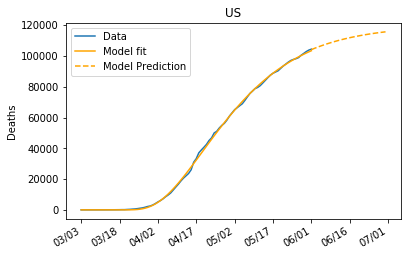

In [115]:
run_and_plot("US", 0)

## China

{'alpha': 1.2067968058741276, 'b': 12.253908528553358, 'r_s': 9.999999937131898, 'p_L_to_R': 8.420976592386265e-09, 'p_I_to_C': 0.09999999999999999, 'p_C_to_D': 0.7999999998744722, 's': 0.003}
529228.0897142214


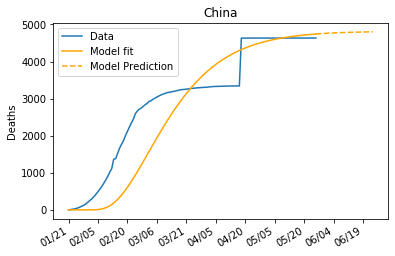

In [116]:
run_and_plot("China", 0)

## Brazil

{'alpha': 5.699977135946738, 'b': 3.087202387139641, 'r_s': 9.52938321562177, 'p_L_to_R': 8.42957430497834e-18, 'p_I_to_C': 0.09997589044510799, 'p_C_to_D': 0.7999999907681551, 's': 0.003}
105409.72010116206


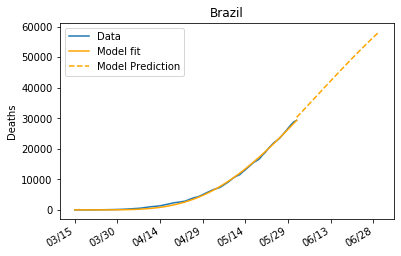

In [117]:
run_and_plot("Brazil", 0)

## India

{'alpha': 5.042667093929421, 'b': 2.8961107712666716, 'r_s': 9.999994646651823, 'p_L_to_R': 2.1090985299546636e-06, 'p_I_to_C': 0.09999999987214268, 'p_C_to_D': 0.7999999999259204, 's': 0.003}
7193.682013086762


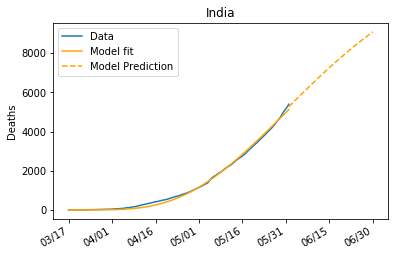

In [118]:
run_and_plot("India", 0)

## Germany

{'alpha': 0.6769939548355048, 'b': 20.147865632273177, 'r_s': 9.999991313758608, 'p_L_to_R': 4.3613872542323235e-08, 'p_I_to_C': 0.09999999969339057, 'p_C_to_D': 0.7999952870195096, 's': 0.003}
9028.965068015554


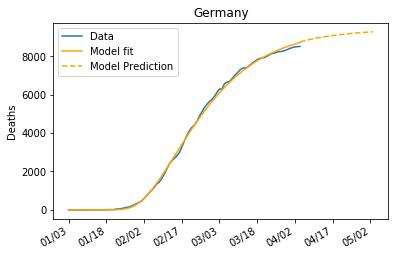

In [119]:
run_and_plot("Germany", 0)

## Italy

{'alpha': 1.2666867827631183, 'b': 14.419534425832087, 'r_s': 9.999999997706245, 'p_L_to_R': 3.4534781115979165e-09, 'p_I_to_C': 0.09999999999999999, 'p_C_to_D': 0.7999999999999757, 's': 0.003977917414476813}
5534658.725077873


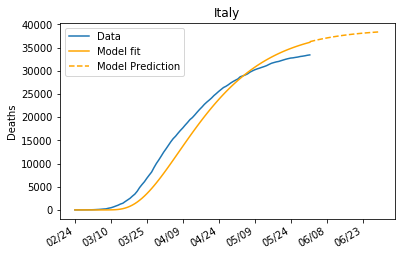

In [120]:
run_and_plot("Italy", 0)

## Spain

{'alpha': 1.283659975780149, 'b': 14.210141350389529, 'r_s': 9.999999997754111, 'p_L_to_R': 1.7794286071630068e-09, 'p_I_to_C': 0.09999999999999999, 'p_C_to_D': 0.7999999999996842, 's': 0.005777400410701614}
12934219.829153543


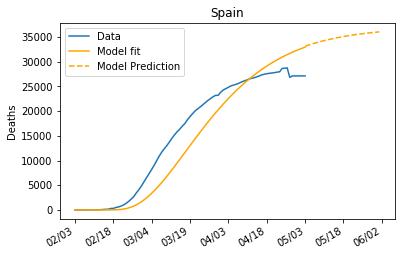

In [121]:
run_and_plot("Spain", 0)

## United Kingdom

{'alpha': 1.2822423463966157, 'b': 14.502044760114272, 'r_s': 9.99999999963139, 'p_L_to_R': 6.346913803123641e-12, 'p_I_to_C': 0.09999999999999999, 'p_C_to_D': 0.7999999999999998, 's': 0.00404760356180787}
1903130.1146972673


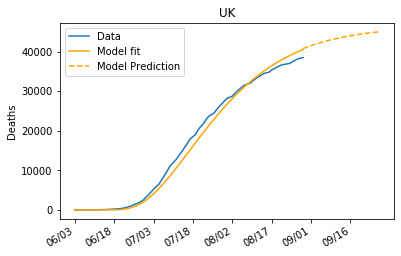

In [124]:
run_and_plot("UK", 0)

## France

{'alpha': 1.1667294895867253, 'b': 15.206798783717034, 'r_s': 9.999999989430592, 'p_L_to_R': 1.974040869684269e-11, 'p_I_to_C': 0.09999999999999999, 'p_C_to_D': 0.7999999999999939, 's': 0.003}
3814433.7646824718


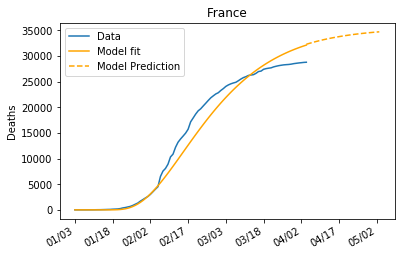

In [125]:
run_and_plot("France", 0)

## Canada

{'alpha': 1.3577169932929254, 'b': 12.631422227187173, 'r_s': 8.211062601738675, 'p_L_to_R': 0.799998315456165, 'p_I_to_C': 0.09999994296764327, 'p_C_to_D': 0.7999440304176756, 's': 0.003}
2822.410360216714


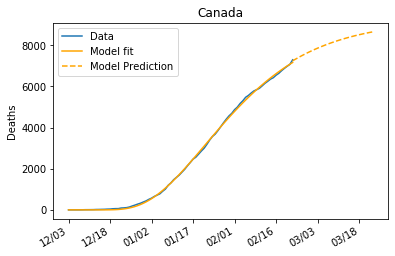

In [126]:
run_and_plot("Canada", 0)

## Netherlands

{'alpha': 1.199593786135302, 'b': 12.910209502998088, 'r_s': 9.999999952789661, 'p_L_to_R': 4.9303825437569476e-11, 'p_I_to_C': 0.09999999999999999, 'p_C_to_D': 0.7999999999999999, 's': 0.003}
313482.3998511483


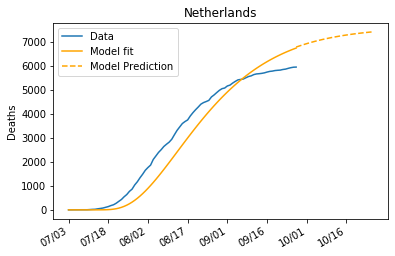

In [127]:
run_and_plot("Netherlands", 0)

## Use Johns Hopkins Global Data 

In [249]:
set(confirmed_df["country"])

{'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',

In [338]:
def run_and_predict(country, outbreak_shift):

    # Use Johns Hopkins github data
    confirmed_df = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
    deaths_df = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
    recoveries_df = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

    confirmed_df.rename(columns={"Country/Region" : "country"}, inplace=True)
    deaths_df.rename(columns={"Country/Region" : "country"}, inplace=True)
    recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)

    confirmed_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
    deaths_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
    recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)
    
    confirmed_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
    deaths_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
    recoveries_df.rename(columns={"Korea, South" : "South Korea"}, inplace=True)
    
    
    # cols = confirmed_df.keys() gives
    # 'Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20' ... etc
    cols = confirmed_df.keys()

    confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
    deaths = deaths_df.loc[:, cols[4]:cols[-1]]
    recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

    dates = confirmed.keys()

    countryConfirmed = [] 
    countryDeaths = []
    countryRecovery = []

    for i in dates:
        # case studies 
        countryConfirmed.append(confirmed_df[confirmed_df['country']== country ][i].sum())

        countryDeaths.append(deaths_df[deaths_df['country']==country][i].sum())

        countryRecovery.append(recoveries_df[recoveries_df['country']==country][i].sum())

    countryConfirmed = np.array(countryConfirmed)
    countryDeaths = np.array(countryDeaths)
    countryRecovery = np.array(countryRecovery)


    # find the case when equal or more than 100 infection cases detected
    idx = np.where(countryConfirmed>=100)
    deathData = countryDeaths[idx]

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    #create outbreak shift
    days = outbreak_shift + len(deathData)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), deathData))
    else: y_data = deathData[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array
    
    # fit model to deaths
#     def fitter(x, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s):
#         ret = Model(days, agegroups, beds_per_10k, R_0_start, k, x0, R_0_end, p_L_to_R, p_I_to_C, p_C_to_D, s)
#         return ret[7][x]
    def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
        ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
        return ret[7][x]
    mod = lmfit.Model(fitter)
    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
    params = mod.make_params()
    fit_method = "leastsq"
    result = mod.fit(y_data, params, method="least_squares", x=x_data)
#     print(result.best_values)
    print(np.mean(result.residual **2))
    
    # forward predict
#     dates = countryData["date"].values

    first_date = dates[idx][0]
    full_days = len(y_data) + 30
    x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
    predict_range = full_days - len(y_data)
    forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
    death_projection = forecast[7]
      
    return x_data, y_data, death_projection, predict_range, x_ticks, result.best_values, result

248298.04986533738
236205.7731515836
91838.32802358839
6405.228843031668
6485.538165726187
24862.788623296252
404895.81981824804
35900.58488748132
202943.41142489717
2640.410056660165
1797.0669684500622
79.47746292907506


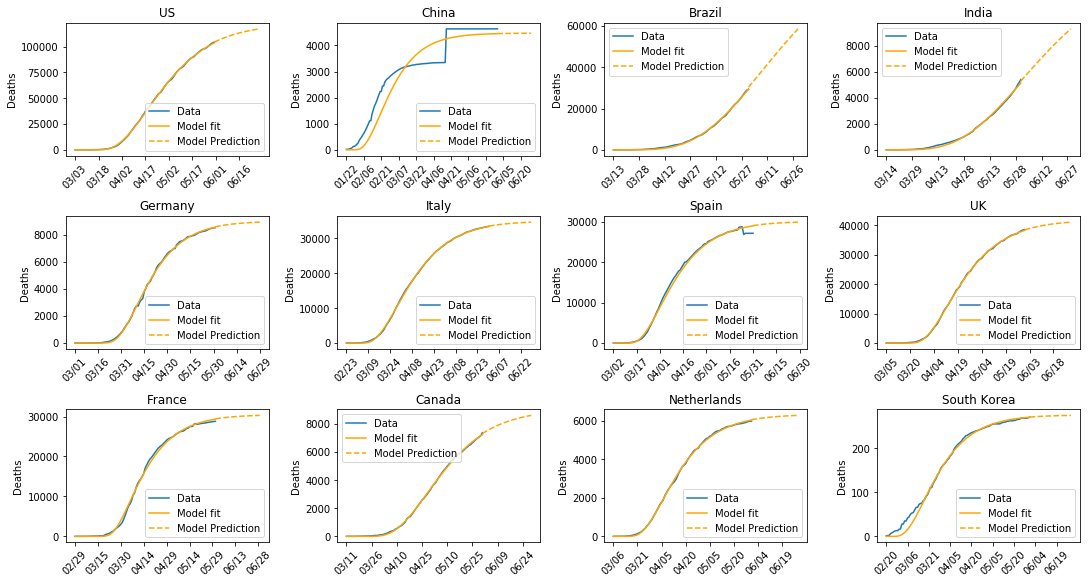

In [376]:
countries = ["US", "China", "Brazil", "India", "Germany", "Italy", "Spain", "UK", "France", "Canada", "Netherlands", "South Korea"]

params_init_min_max = {"p_L_to_R": (0.6, 0.0, 0.8),
                       "alpha": (0.3, 0.1, 5.7), 
                       "b": (20, 0, 40), "r_s": (1, 0.1, 60),
                       "p_I_to_C": (0.05, 0.001, 0.1), "p_C_to_D": (0.5, 0.005, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

fig, axs = plt.subplots(3,4, figsize=(15, 8), constrained_layout=True)
axs = axs.ravel()

country_param_dict = {}
country_death_prediction = {}
country_models = {}
country_dates = {}

for i,country in enumerate(countries):
    x_data, y_data, death_projection, predict_range, x_ticks, best_param, country_model  = run_and_predict(country, 0)
    
    country_param_dict[country] = best_param
    country_death_prediction[country] = (x_data, death_projection)
    country_models[country] = country_model
    country_dates[country] = x_ticks
    
    axs[i].plot(x_data, y_data, label="Data")
    axs[i].plot(x_data, death_projection[:len(y_data)], color="orange", label="Model fit")
    axs[i].plot(np.arange(x_data[-1],x_data[-1]+predict_range), death_projection[len(y_data):], 
         "--", color="orange", label="Model Prediction")
    
    label_idx = np.arange(0, len(x_ticks), 15)
    labels = x_ticks[label_idx].strftime("%m/%d")
    location = np.arange(0, len(death_projection))
    label_location = location[label_idx]; axs[i].set_xticks(label_location)
    axs[i].set_xticklabels(labels, rotation=45); axs[i].set_ylabel("Deaths")
    axs[i].set_title(country) ;axs[i].legend() ; #fig.autofmt_xdate(); 

plt.show()

In [389]:

# countries = ["US", "China", "Brazil", "India", "Germany", "Italy", "Spain", "UK", "France", "Canada", "Netherlands", "South Korea"]
country_dates["China"]



DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', length=161, freq='D')

In [392]:
country = "China"
len(country_dates[country])

161

In [397]:
import copy

country_interval = {}

for i,country in enumerate(countries):

    country_param = country_param_dict[country]

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    full_days = len(country_dates[country])
    
    forecast = Model(full_days, agegroups, beds_per_10k, **country_param)
#     plt.plot(forecast[7], label="projection")

    upper_param = copy.deepcopy(country_param)
    upper_param["p_C_to_D"] = upper_param["p_C_to_D"] + 0.1
    upper_forecast = Model(full_days, agegroups, beds_per_10k, **upper_param)
#     plt.plot(upper_forecast[7], label="upper")

    lower_param = copy.deepcopy(country_param)
    lower_param["p_C_to_D"] = lower_param["p_C_to_D"] - 0.1
    lower_forecast = Model(full_days, agegroups, beds_per_10k, **lower_param)
#     plt.plot(lower_forecast[7], label="lower")
#     plt.legend()
#     plt.show()
    print("\n***********"+ country + "***********")
    print("+",np.mean(upper_forecast[7] - forecast[7]))
    print("-",np.mean(forecast[7] - lower_forecast[7]))
    print("**************************")

    d = {"dates" : country_dates[country], 
         "prediction" :forecast[7],
         "+" :upper_forecast[7] - forecast[7], 
         "-" :lower_forecast[7] - forecast[7]}

    interval_df = pd.DataFrame(data=d)
    country_interval[country] = copy.deepcopy(interval_df)
    
    country_interval[country].to_csv(country+"projection")
    df.to_csv('file_name.csv')
    


***********US***********
+ 5301.191304918162
- 5659.688221267154
**************************

***********China***********
+ 284.99664162496737
- 305.6072464378105
**************************

***********Brazil***********
+ 1613.8796557772566
- 1711.8756624783196
**************************

***********India***********
+ 278.4883870961415
- 295.683675950271
**************************

***********Germany***********
+ 456.28560165218573
- 487.7010954142036
**************************

***********Italy***********
+ 1889.5178102271695
- 2021.5663226892211
**************************

***********Spain***********
+ 1694.9838730275121
- 1813.0837075203017
**************************

***********UK***********
+ 2055.6373168316013
- 2196.229738409854
**************************

***********France***********
+ 1623.4229537588412
- 1736.000613562699
**************************

***********Canada***********
+ 368.07984305570295
- 392.49452479687676
**************************

***********Netherlands*******

In [398]:
country_interval["US"]

,dates,prediction,+,-
0,2020-03-03,0.000000e+00,0.000000e+00,0.000000e+00
1,2020-03-04,5.858813e-07,7.267393e-08,-7.280897e-08
2,2020-03-05,8.925054e-06,1.098385e-06,-1.102345e-06
3,2020-03-06,4.814239e-05,5.885155e-06,-5.915085e-06
4,2020-03-07,1.810944e-04,2.202491e-05,-2.216167e-05
...,...,...,...,...
115,2020-06-26,1.162952e+05,9.955320e+03,-1.071057e+04
116,2020-06-27,1.165607e+05,9.972831e+03,-1.073020e+04
117,2020-06-28,1.168151e+05,9.989568e+03,-1.074897e+04
118,2020-06-29,1.170588e+05,1.000556e+04,-1.076691e+04


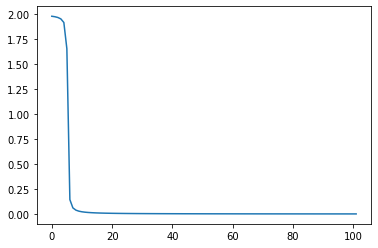

In [274]:
country = "South Korea"
# Use Johns Hopkins github data
confirmed_df = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_df.rename(columns={"Country/Region" : "country"}, inplace=True)
deaths_df.rename(columns={"Country/Region" : "country"}, inplace=True)
recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)

confirmed_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
deaths_df["country"].replace({"United Kingdom": "UK"}, inplace=True)
recoveries_df.rename(columns={"Country/Region" : "country"}, inplace=True)

confirmed_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
deaths_df["country"].replace({"Korea, South": "South Korea"}, inplace=True)
recoveries_df.rename(columns={"Korea, South" : "South Korea"}, inplace=True)


# cols = confirmed_df.keys() gives
# 'Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20' ... etc
cols = confirmed_df.keys()

confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

dates = confirmed.keys()

countryConfirmed = [] 
countryDeaths = []
countryRecovery = []

for i in dates:
    # case studies 
    countryConfirmed.append(confirmed_df[confirmed_df['country']== country ][i].sum())

    countryDeaths.append(deaths_df[deaths_df['country']==country][i].sum())

    countryRecovery.append(recoveries_df[recoveries_df['country']==country][i].sum())

countryConfirmed = np.array(countryConfirmed)
countryDeaths = np.array(countryDeaths)
countryRecovery = np.array(countryRecovery)


# find the case when equal or more than 100 infection cases detected
idx = np.where(countryConfirmed>=100)
deathData = countryDeaths[idx]

days = len(deathData)
t = np.linspace(0, days-1, days)

b = 5.276639391784356
r_s = 59.99999980327082

r0 = R0_t(t, b, r_s)

plt.plot(t, r0)

# def R0_t(t, b, r_s):
#     return (2 / np.pi) * np.arctan(-(t - b) / 10 * r_s) + 1.0


# Validation

In [ ]:
from sklearn.model_selection import train_test_split

def Validate(country):
    outbreak_shift = 0
    
    if country == 'China': 
        deaths = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
        # rename the column header so that it is same as other data
        deaths.rename(columns={'confirmed_ttl':'cases_ttl'}, inplace=True) 
        
    else: deaths = pd.read_csv("Data/world_cases_deaths_EUopendataportal.csv", header = 0)
    
    deaths = deaths[deaths.country == country]

    # find the case when equal or more than 100 infection cases detected
    deaths = deaths.loc[deaths["cases_ttl"].values>=100]
    data = deaths["deaths_ttl"].values

    # agegroups
    ages = pd.read_csv("Data/agegroups_UNdata.csv")
    agegroups = ages[ages.country_area == country].values[0][2:]
    N = sum(agegroups) #ttl pop

    # beds
    beds = pd.read_csv("Data/beds_UNdata.csv", header=0)
    beds = beds[['country_area','beds']]
    beds = beds.rename(columns={"country_area": "Country", "beds": "ICU_Beds"})
    beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
    beds_per_10k = beds_lookup[country]

    #create outbreak shift
    days = outbreak_shift + len(data)
    if outbreak_shift >= 0:y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else: y_data = data[-outbreak_shift:]

    x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array


    # This represents test size to be the last 30%, 20% and 10% of data
    test_sizes = [0.3, 0.2, 0.1, 0.05] 

    param_vec = []
    test_errors = []
    train_errors = []

    for test_size in test_sizes:
        print(test_size)
        X_train, X_test, Y_train, Y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle = False) # make sure shuffle is False

        def fitter(x, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s):
                ret = Model(days, agegroups, beds_per_10k, alpha, b, r_s, p_L_to_R, p_I_to_C, p_C_to_D, s)
                return ret[7][x]
        mod = lmfit.Model(fitter)
        for kwarg, (init, mini, maxi) in params_init_min_max.items():
            mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
        params = mod.make_params()
        fit_method = "leastsq"
        result = mod.fit(Y_train, params, method="least_squares", x=X_train)

        ## store parameter values
        param_vec.append(result.best_values)

        # forward predict
        full_days = len(x_data)
        forecast = Model(full_days, agegroups, beds_per_10k, **result.best_values)
        death_projection = forecast[7]


        train_error = np.linalg.norm(Y_train - death_projection[:len(Y_train)], 2) ## divide by number of train set
        test_error = np.linalg.norm(Y_test - death_projection[-len(Y_test):], 2) ## divide by number of test set

        print("Train Error: {0}".format( train_error ))
        print("Test Error: {0}".format( test_error ))

        train_errors.append(train_error)
        test_errors.append(test_error)

    best_case = np.argmin(test_errors)
    best_parameters = param_vec[best_case]

    print("Best Validation case is when test size is remaining {0} %".format(test_sizes[best_case]*100))
    
    plt.figure()
    plt.plot((1-np.array(test_sizes)) * 100, test_errors)
    plt.xlabel("Train Set Percentage")
    plt.ylabel(r"$L_2$ Norm Error")
    plt.title("{0} Data Validation".format(country))
    plt.show()
    
    return best_parameters

In [ ]:
best_param_each_country = dict()

best_param_each_country["US"] = Validate("US")

In [ ]:
best_param_each_country["China"]  = Validate("China")

In [ ]:
best_param_each_country["Brazil"]  = Validate("Brazil")

In [ ]:
India_best_param = Validate("India")

In [ ]:
Germany_best_param = Validate("Germany")

In [ ]:
Italy_best_param = Validate("Italy")

In [ ]:
Spain_best_param = Validate("Spain")

In [ ]:
UK_best_param = Validate("UK")

In [ ]:
France_best_param = Validate("France")

In [ ]:
Canada_best_param = Validate("Canada")

In [ ]:
Netherlands_best_param = Validate("Netherlands")